# Load

In [25]:
from collections import defaultdict
import json
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

sections = {
    'A': ['farmer',
          'woodcutter',
          'fisherman',
          'horticulturist'],

    'J': ['software_engineer',
          'cybersecurity_specialist',
          'data_scientist',
          'telecommunications_technician'],

    'K': ['investment_analyst',
          'actuary',
          'insurance_claims_adjuster',
          'financial_advisor'],

    'P': ['primary_school_teacher',
          'university_professor',
          'vocational_trainer',
          'special_education_teacher'],

    'Q': ['doctor',
          'nurse',
          'physical_therapist',
          'psychologist'],

    'R': ['actor',
          'musician',
          'artist',
          'writer']
}

section_name = {
    'A': 'A. Agriculture, forestry and fishing',
    'J': 'J. Information and communication',
    'K': 'K. Financial and insurance activities',
    'P': 'P. Education',
    'Q': 'Q. Human health and social work activities',
    'R': 'R. Arts, entertainment and recreation'
}

INTENTS = [
    'FindAttraction',
    'FindRestaurants',
    'FindMovie',
    'LookUpMusic',
    'SearchHotel',
    'FindEvents'
]

def find_intent(raw):
    canonical_intents = {
        'findattraction': 'FindAttraction',
        'findrestaurant': 'FindRestaurants',
        'findrestaurants': 'FindRestaurants',
        'findmovie': 'FindMovie',
        'lookmusic': 'LookUpMusic',
        'lookupmusic': 'LookUpMusic',
        'searchhotel': 'SearchHotel',
        'findevent': 'FindEvents',
        'findevents': 'FindEvents'
    }
    cleaned = raw.lower().replace(" ", "").replace("_", "")
    for k in canonical_intents:
        if k in cleaned:
            return canonical_intents[k]
    return None


personas = []

for path in sorted(glob('simulation_output/occupation20_no_strategy/*.json')):
    with open(path, 'r') as f:
        data = json.load(f)

    occupation = Path(path).stem
    for s, occupations in sections.items():
        if occupation in occupations:
            section = s
            break
    for p in data:
        success_rate = (sum(1 for reason in p['terminate_reason'] if reason == 'Success') /
                        len(p['terminate_reason']))

        average_turn = sum(x for x in p['num_turns']) / len(p['num_turns'])

        average_turn_w_success = np.mean([
            p['num_turns'][i]
            for i in range(len(p["num_turns"]))
            if p['terminate_reason'][i] == 'Success'
        ])

        continue_ratio_micro = (
            sum(
                1
                for conv in p['conversations'].values()
                for c in conv
                if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')
            ) /
            sum(
                1
                for conv in p['conversations'].values()
                for c in conv
                if c['role'] == 'user'
            )
        )

        continue_ratio_macro = np.mean([
            sum(1 for c in conv if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')) /
            sum(1 for c in conv if c['role'] == 'user')
            for conv in p['conversations'].values()
        ])

        intent_count = {intent: 0 for intent in INTENTS}
        intent_count_strict = {intent: 0 for intent in INTENTS}
        success_intent_count = {intent: 0 for intent in INTENTS}
        switch_count = 0
        switch_count_strict = 0
        switch_count_success = 0
        switch_count_strict_success = 0
        for i, conv in enumerate(p['conversations'].values()):
            success = p['terminate_reason'][i] == 'Success'
            switch_cnt_strict = 0
            last_intent = None
            last_intent_strict = None

            if success:
                success_intent_count[find_intent(conv[-1]['thought'])] += 1
            
            for c in conv:
                if c['role'] != 'user':
                    continue

                intent = find_intent(c.get('thought', ''))
                if c.get('thought', '').startswith('The user did not implicitly mention any potential intent, I should continue the chit-chat.'):
                    last_intent_strict = None
                if intent is not None:
                    if last_intent is not None and intent != last_intent:
                        switch_count += 1
                        if success:
                            switch_count_success += 1
                        intent_count[last_intent] += 1
                    last_intent = intent

                    if last_intent_strict is not None and intent != last_intent_strict:
                        switch_count_strict += 1
                        if success:
                            switch_count_strict_success += 1
                        intent_count_strict[last_intent_strict] += 1
                    last_intent_strict = intent
                    
            if last_intent is not None:
                switch_count += 1
                if success:
                    switch_count_success += 1
                intent_count[last_intent] += 1
            if last_intent_strict is not None:
                switch_count_strict += 1
                if success:
                    switch_count_strict_success += 1
                intent_count_strict[last_intent_strict] += 1

        switch_count /= len(p['conversations'])
        switch_count_strict /= len(p['conversations'])
        if sum(1 for msg in p['terminate_reason'] if msg == 'Success') > 0:
            switch_count_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')
            switch_count_strict_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')

        personas.append({
            'occupation': occupation,
            'section': section,
            'success rate': success_rate,
            'average turn': average_turn,
            'average turn w/ success': average_turn_w_success,
            'continue ratio micro': continue_ratio_micro,
            'continue ratio macro': continue_ratio_macro,
            'switch count': switch_count,
            'switch count strict': switch_count_strict,
            'switch count w/ success': switch_count_success,
            'switch count w/ success strict': switch_count_strict_success,
        } | {
            ('intent count', k): v
            for k, v in intent_count.items()
        } | {
            ('intent count strict', k): v
            for k, v in intent_count_strict.items()
        } | {
            ('success intent count', k): v
            for k, v in success_intent_count.items()
        })

persona_df = pd.DataFrame.from_dict(personas)
persona_df.columns = pd.MultiIndex.from_tuples([
    (col, '') if not isinstance(col, tuple) else col for col in persona_df.columns
])
persona_df

/tmp2/zion/conda/envs/salesagent/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tmp2/zion/conda/envs/salesagent/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


occupation section success rate average turn average turn w/ success  \
                                                                           
0        actor       R     0.600000    14.666667               11.111111   
1        actor       R     0.266667    17.466667               10.500000   
2        actor       R     0.400000    16.400000               11.000000   
3        actor       R     0.533333    15.200000               11.000000   
4        actor       R     0.266667    17.866667               12.000000   
..         ...     ...          ...          ...                     ...   
475     writer       R     0.333333    16.533333                9.600000   
476     writer       R     0.200000    18.133333               10.666667   
477     writer       R     0.000000    20.000000                     NaN   
478     writer       R     0.466667    15.333333               10.000000   
479     writer       R     0.066667    19.200000               18.000000   

    continue ratio micro continue ratio macro switch count  \
                                                             
0               0.408000             0.341938     1.400000   
1               0.363014             0.339827     2.000000   
2               0.413043             0.372439     1.266667   
3               0.534884             0.452189     2.333333   
4               0.449664             0.423319     2.066667   
..                   ...                  ...          ...   
475             0.431655             0.383223     1.333333   
476             0.688742             0.662165     2.200000   
477             0.400000             0.400000     1.133333   
478             0.561538             0.465051     1.733333   
479             0.641509             0.624444     1.266667   

    switch count strict switch count w/ success  ... intent count strict  \
                                                 ...           FindMovie   
0              1.333333                1.111111  ...                   3   
1              1.533333                1.500000  ...                   6   
2              1.066667                1.500000  ...                   5   
3              2.333333                2.000000  ...                   1   
4              1.666667                2.250000  ...                   1   
..                  ...                     ...  ...                 ...   
475            1.200000                1.400000  ...                   0   
476            2.133333                1.666667  ...                   4   
477            0.733333                0.000000  ...                   1   
478            1.733333                1.142857  ...                   1   
479            1.133333                2.000000  ...                   0   

                                       success intent count                  \
    LookUpMusic SearchHotel FindEvents       FindAttraction FindRestaurants   
0             0           3          7                    2               1   
1             0           0         10                    1               0   
2             0           1          5                    0               1   
3             1           4         14                    1               0   
4             0           1          3                    3               0   
..          ...         ...        ...                  ...             ...   
475           0           3          4                    0               1   
476           0           9          4                    0               2   
477           0           0          1                    0               0   
478           0           9          8                    0               1   
479           1           2          0                    0               0   

                                                  
    FindMovie LookUpMusic SearchHotel FindEvents  
0           1           0           1          4  
1           1           0           0 

In [26]:
agg_dict = {}
for col in persona_df.columns:
    if col[0] in ['occupation', 'section']:
        continue
    if col[0] in ['intent count', 'intent count strict', 'success intent count']:
        agg_dict[col] = 'sum'
    else:
        agg_dict[col] = 'mean'

section_df = persona_df.drop(columns=[('occupation', '')]).groupby('section', as_index=False).agg(agg_dict)
section_df.set_index('section', inplace=True)
section_df.index = section_df.index.map({
    'A': 'Agr',
    'J': 'Info',
    'K': 'Fin',
    'P': 'Edu',
    'Q': 'Heal',
    'R': 'Arts'
})

section_df.to_csv('section_result.csv')

float_cols = section_df.select_dtypes(include='float').columns
format_dict = {col: "{:.2f}" for col in float_cols}

styled_section_df = (
    section_df.style
    .format(format_dict)
    .set_caption("Section Aggregated Results")
    .set_table_styles(
        [
            {
                'selector': 'th.col_heading',
                'props': 'border: 2px solid black;'
            }
        ]
    )
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(styled_section_df)


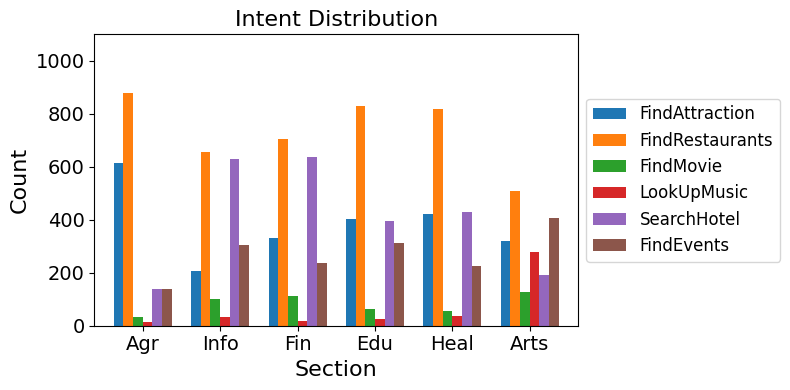

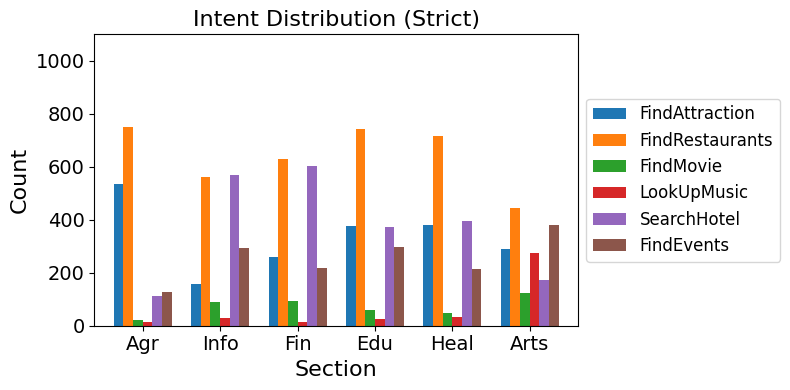

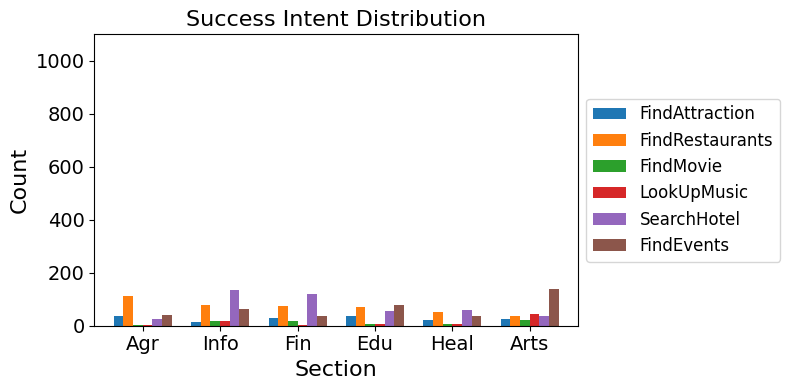

In [27]:
def plot_dist(df, title='', xlabel='', ylabel=''):
    # df = df.rename(index=section_name)
    df.plot(kind='bar', figsize=(8, 4), width=0.75, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    # plt.xticks(rotation=20, ha='right')
    plt.xticks(rotation=0) 
    plt.ylabel(ylabel, fontsize=16)
    plt.ylim(0, 1100)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
    plt.tight_layout()
    plt.show()


df = section_df.loc[:, pd.IndexSlice['intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution', xlabel='Section', ylabel='Count')

df = section_df.loc[:, pd.IndexSlice['intent count strict', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution (Strict)', xlabel='Section', ylabel='Count')

df = section_df.loc[:, pd.IndexSlice['success intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Success Intent Distribution', xlabel='Section', ylabel='Count')

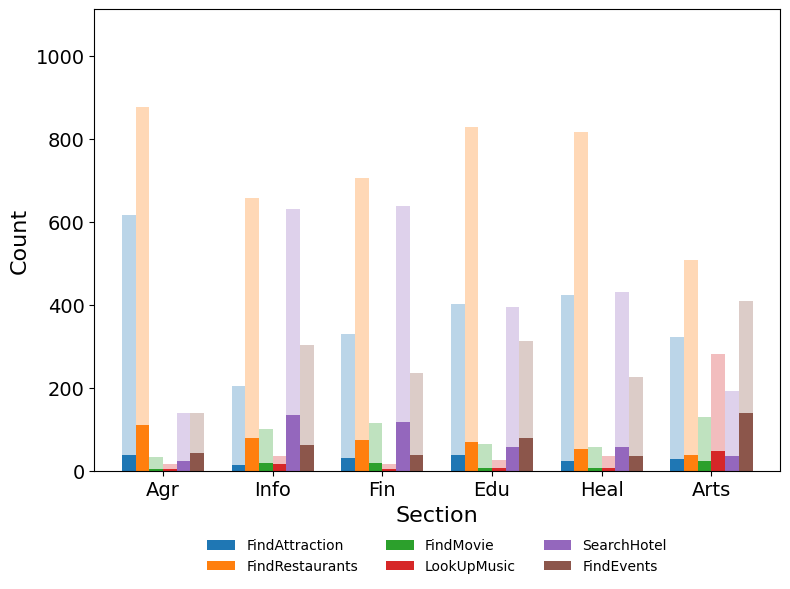

In [29]:
import matplotlib.pyplot as plt

def plot_overlay_bar(base_df, overlay_df, title='', xlabel='', ylabel=''):
    base_df = base_df.rename(columns=str)
    overlay_df = overlay_df.rename(columns=str)
    categories = base_df.columns.tolist()

    # 使用 matplotlib 預設 tab10 顏色
    color_map = plt.get_cmap('tab10')
    colors = [color_map(i) for i in range(len(categories))]

    fig, ax = plt.subplots(figsize=(8, 6))

    # 底層圖（淺色）
    base_df.plot(
        kind='bar', ax=ax, width=0.75, fontsize=14,
        color=[(*c[:3], 0.3) for c in colors],  # alpha=0.4
        legend=False
    )

    # 上層圖（正常不透明）
    overlay_df.plot(
        kind='bar', ax=ax, width=0.75, fontsize=14,
        color=[(*c[:3], 1.0) for c in colors],
        legend=False
    )

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(rotation=0)
    # plt.ylim(0, max(base_df.max().max(), overlay_df.max().max()) * 1.05)
    plt.ylim(0, 1111.95)

    # 圖例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=(*c[:3], 1.0), label=f'{col}')
        for c, col in zip(colors, categories)
    ]
    plt.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        ncol=len(legend_elements) // 2,  # 一橫排
        fontsize=10,
        frameon=False
    )

    plt.tight_layout()
    plt.show()

base_df = section_df.loc[:, pd.IndexSlice['intent count', :]]
base_df.columns = base_df.columns.droplevel(0)

overlay_df = section_df.loc[:, pd.IndexSlice['success intent count', :]]
overlay_df.columns = overlay_df.columns.droplevel(0)

plot_overlay_bar(base_df, overlay_df,
                 title='Intent vs Success Count by Category',
                 xlabel='Section', ylabel='Count')


- Intent Distribution
    - FindRestaurants 和 SearchHotel 幾乎在所有 section 中都很突出，顯示這兩個任務對大部分人都具吸引力。
    - Section K (金融保險) 和 J (資訊與通訊) 對 SearchHotel 與 FindRestaurants 表現活躍，可能這些行業的人習慣出差或有規劃活動的需求。
    - Section R (藝術、娛樂、休閒) 在 FindEvents 上明顯高於其他類別，這合理，因為此領域的人對活動類資訊較敏感。
    - Section P (教育) 和 Q (健康照護與社工) 的分布相對平均，表示他們的需求較多樣。
- Intent Distribution（Strict）
    - FindRestaurants、SearchHotel 依然熱門，但各 section 間的差異略為收斂。
	- FindEvents 在 Section R 的比例幾乎沒有掉，顯示此 section 的 personas 對活動資訊是真實感興趣的，而非 SalesBot 誤判。
	- 整體來說 intent 數有下降，代表 SalesBot 有不錯的辨識使用者興趣的能力。
- Success Intent Distribution
    - 成功次數整體下降明顯，特別是 Section K、J、Q，可能表示這些領域的 persona 較難被 SalesBot 說服。
    - FindRestaurants 成功率依然最高，可能因為這任務需求明確、資訊容易提供。
    - Section R 在 FindEvents 上有大量成功，這再次佐證 R 類使用者對活動類需求真實且具體。
    - Section P 的成功率在 SearchHotel 和 FindEvents 上有不錯表現，可能因教育工作者有計畫旅行的需求。

# ANOVA

In [8]:
import pandas as pd
from scipy import stats
import itertools

df = persona_df.drop(columns=[('occupation', '')])
cols = list(df.columns)
cols.remove(('section', ''))

sections = df['section'].unique()

results = []
for col in cols:
    # 全體 ANOVA
    groups = [group[col].values for name, group in df.groupby('section')]
    _, p_value = stats.f_oneway(*groups)
    results.append({
        'metric': col,
        'group': 'All sections',
        'p_value': round(p_value, 6)
    })

    # 任兩組之間的 ANOVA
    for sec1, sec2 in itertools.combinations(sections, 2):
        group1 = df[df['section'] == sec1][col].values
        group2 = df[df['section'] == sec2][col].values
        _, p_value = stats.f_oneway(group1, group2)
        results.append({
            'metric': col,
            'group': f'{sec1} vs {sec2}',
            'p_value': round(p_value, 6)
        })

anova_df = pd.DataFrame(results)

# 排序 group
anova_df['group'] = pd.Categorical(
    anova_df['group'],
    categories=['All sections'] +
    sorted(g for g in anova_df['group'].unique() if g != 'All sections'),
    ordered=True
)

# Pivot 成 group vs metric 的 p-value 表格
anova_pivot = anova_df.pivot(index='group', columns='metric', values='p_value')
anova_pivot.title = 'ANOVA p-value'
anova_pivot.columns = pd.MultiIndex.from_tuples(anova_pivot.columns)
anova_pivot.to_csv('anova_pvalue.csv')

# 顯著性標示樣式
def highlight_significant(val):
    if pd.isna(val):
        return ''
    return 'background-color: #ffcccc' if val < 0.05 else ''

# 套用樣式
styled = anova_pivot.style.set_table_styles(
    [
        {
            'selector': 'th.col_heading',
            'props': 'border: 2px solid black;'
        }
    ]
).map(highlight_significant).format("{:.2f}").set_caption("ANOVA p-value")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(styled)

age, gender, occupation
suc     x       intent distribution
strategy vs no-strategy
lightweight pipeline